In [1]:
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


In [2]:
import rf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from datetime import datetime
from collections import defaultdict
import pygmt
import random
from joblib import Parallel, delayed

import warnings

warnings.filterwarnings("ignore")


In [3]:
def peak_delay(trace: rf.rfstream.RFTrace) -> float:
    return trace.times()[np.argmax(trace.data)] - (
        trace.stats.onset - trace.stats.starttime
    )


def _stack(stream: rf.RFStream) -> rf.RFStream():
    """
    TO BE USED ONLY WHEN STREAM ONLY CONTAINS TRACES FROM THE SAME STATION
    RFStream.stack() forces stacking for separate ids, including channels
    Access original obspy Stream.stack() to stack BHR and HHR channels
    Copies meta data as in RFStream.stack()
    """
    _stream = stream.copy()  # Stream.stack() operates in place
    stack = super(rf.RFStream, _stream).stack(group_by="{network}.{station}")
    assert len(stack) == 1
    tr = stream[0]
    data = stack[0].data
    header = {}
    for entry in (
        "network",
        "station",
        "sampling_rate",
        "phase",
        "moveout",
        "station_latitude",
        "station_longitude",
        "station_elevation",
        "processing",
    ):
        if entry in tr.stats:
            header[entry] = tr.stats[entry]
    _tr = rf.rfstream.RFTrace(data=data, header=header)
    if "onset" in tr.stats:
        onset = tr.stats.onset - tr.stats.starttime
        _tr.stats.onset = _tr.stats.starttime + onset
    return rf.RFStream(_tr)


def quality_filter(stream: rf.RFStream) -> rf.RFStream:
    """ "
    Applies various final quality controlls to the RFs
    starttime and end time are in seconds relative to onset
    """
    rf_station_dict = defaultdict(rf.RFStream)
    for trace in stream:
        # Only keep traces where largest arrival is positive
        if trace[np.argmax(np.abs(trace.data))] < 0:
            continue
        # Only keep traces where largest arrival is within 2 seconds after direct p
        delay = peak_delay(trace)
        if delay > 2 or delay < 0:
            continue
        rf_station_dict[trace.stats.station] += rf.RFStream([trace])

    # Only keep stations with 10 or more traces
    rf_station_dict = {
        k: v.sort(["back_azimuth"]) for k, v in rf_station_dict.items() if len(v) >= 10
    }

    return sum(rf_station_dict.values(), start=rf.RFStream())


def plot_map(stream: rf.RFStream, save_dir=".", show=False):
    region = [112, 155, -46, -8]
    ln_min, ln_max, lt_min, lt_max = region
    projection = (
        f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/15c"
    )

    lats = np.zeros(len(stream), dtype=float)
    lons = np.zeros_like(lats, dtype=float)
    nets = np.zeros_like(lats, dtype=str)
    delays = np.zeros_like(lats, dtype=float)

    for i, trace in enumerate(stream):
        lats[i] = trace.meta.station_latitude
        lons[i] = trace.meta.station_longitude
        nets[i] = trace.meta.network
        delays[i] = trace.stats.delay

    fig = pygmt.Figure()
    fig.basemap(region=region, projection=projection, frame=True)
    fig.coast(
        region=region,
        projection=projection,
        shorelines=1,
        land="#ffffe6",
        water="#e6ffff",
        borders="2/1p,grey",
    )

    pygmt.makecpt(cmap="hot", truncate=[0, 0.8], series=[0, 1, 0.1],background="o", reverse=True)

    fig.plot(
        region=region,
        projection=projection,
        x=lons,
        y=lats,
        style=f"tc",
        fill=delays,
        cmap=True,
        size=np.full_like(lons, 0.25),
    )
    fig.colorbar(
        region=region,
        projection=projection,
        frame=["af+lDelay Time TPsb (s)", f"y+lmax={delays.max():.2f}"],
        position="JBC+ef",
    )
    if save_dir is not None:
        mapfile = os.path.join(save_dir, "delay_map.pdf")
        fig.savefig(mapfile)
    if show:
        fig.show()


In [4]:
# Get list of networks for which we have RFs
try:
    dataroot = os.environ["DATADIR"]
except KeyError:
    dataroot = os.path.join("data","rf_data")
networks = [
    net[:2]
    for net in os.listdir(dataroot)
    if len(net.split("-")[0]) == 2 and net.split("-")[1] == "analysis"
]


In [11]:
def load_network_rfs(network: str):
    """
    Loads the rfs for a network and performs some initial quality filtering
    Returns a stream for the network that has been trimmed and moveout corrected
    """
    network_dir = os.path.join(dataroot, f"{network}-analysis")
    try:
        latest_run = max(
            [
                os.path.join(network_dir, d)
                for d in os.listdir(network_dir)
                if os.path.isdir(os.path.join(network_dir, d)) and d != "corrections"
            ],
            key=os.path.getmtime,
        )
    except ValueError as e:
        print(f"No run found for network {network}.")
        return (network, 0, 0)

    # Grab the latest .h5 file - should be the outputs of qc
    try:
        h5_file = max(
            [
                os.path.join(latest_run, f)
                for f in os.listdir(latest_run)
                if os.path.splitext(f)[1] == ".h5"
            ],
            key=os.path.getmtime,
        )
    except ValueError as e:
        print(f"No run found for network {network}.")
        return (network, 0, 0)

    try:
        stream = rf.read_rf(h5_file, format="h5")
    except:
        print(f"Something went wrong when reading {h5_file}. Moving on...")
        return (network, 0, 0)
    # Drop transverse component
    stream = stream.select(channel="??R")

    # Trim to a reasonable time length
    starttime = -5
    endtime = 10
    stream = stream.trim2(starttime, endtime, reftime="onset")

    stream.moveout()

    # Count initial number of stations and traces
    nstations = len(set([trace.stats.station for trace in stream]))
    ntraces = len(stream)

    # Apply quality filter
    stream = quality_filter(stream)
    if len(stream) == 0:
        print(f"Nothing left after quality control for network {network}. Moving on...")
        return (network, nstations, ntraces)

    return (stream, nstations, ntraces)


def get_station_stack_delays(stream: rf.RFStream):
    # Station dictionary
    rf_station_dict = defaultdict(rf.RFStream)
    for trace in stream:
        rf_station_dict[trace.stats.station] += rf.RFStream([trace])

    # stack stations individually, otherwise station coordinates also get stacked
    stacks = rf.RFStream()
    for v in rf_station_dict.values():
        stacks += _stack(v)

    # Get delay of each stack
    for stack in stacks:
        delay = peak_delay(stack)
        if delay >= 0:
            stack.stats["delay"] = delay
        else:
            print(f"Negative delay obtained for {stack.stats.network}.{stack.stats.station}")
            stacks.remove(stack)

    return stacks.sort(["delay"])


In [12]:
result = Parallel(n_jobs=-1)(delayed(load_network_rfs)(net) for net in networks)
rfstream = rf.RFStream()  # Stream with every RF
init_nstations = {}
init_ntraces = {}
for res in result:
    _netstream, _nstations, _ntraces = res
    if isinstance(_netstream, rf.RFStream):
        net = _netstream[0].stats.network
        rfstream += _netstream
    elif isinstance(_netstream, str):
        net = _netstream
    init_nstations[net] = _nstations
    init_ntraces[net] = _ntraces
del result


Nothing left after quality control for network IU. Moving on...
Nothing left after quality control for network II. Moving on...


In [13]:
# Remove traces with exceedingly large amplitudes that will dominate the stacks
log10_amp_max = np.array([tr.stats.log10_amp_max for tr in rfstream])
mean = np.mean(log10_amp_max)
stddev = np.std(log10_amp_max)
normed = (log10_amp_max - mean) / stddev
amplitude_threshold = 4  # in units of stddev
indices = np.where(np.abs(normed) <= amplitude_threshold)[0]
rfstream = rf.RFStream(map(rfstream.__getitem__, indices))


In [18]:
# Count remaining stations and traces
empty_networks = []
for net in networks:
    stream = rfstream.select(network=net)
    nstations = len(set([trace.stats.station for trace in stream]))
    ntraces = len(stream)
    print(f"{net}: {nstations}/{init_nstations[net]} stations kept after quality control")
    print(f"{net}: {ntraces}/{init_ntraces[net]} radial RFs kept after quality control")
    if nstations == 0 or ntraces == 0:
        empty_networks.append(net)
for empty in empty_networks:
    networks.remove(empty)


7E: 3/6 stations kept after quality control
7E: 30/65 radial RFs kept after quality control
7D: 6/7 stations kept after quality control
7D: 84/120 radial RFs kept after quality control
1Q: 78/87 stations kept after quality control
1Q: 4107/5624 radial RFs kept after quality control
1P: 22/24 stations kept after quality control
1P: 1425/2243 radial RFs kept after quality control
4J: 48/52 stations kept after quality control
4J: 2826/4294 radial RFs kept after quality control
3G: 62/65 stations kept after quality control
3G: 3706/4628 radial RFs kept after quality control
S1: 16/43 stations kept after quality control
S1: 372/701 radial RFs kept after quality control
6C: 16/16 stations kept after quality control
6C: 770/1028 radial RFs kept after quality control
1E: 16/16 stations kept after quality control
1E: 618/814 radial RFs kept after quality control
ZR: 51/52 stations kept after quality control
ZR: 3577/4410 radial RFs kept after quality control
5G: 39/40 stations kept after qualit

In [19]:
empty_networks

['IU', 'II']

In [9]:
rfstacks = rf.RFStream()  # Stream with station stacks
for net in networks:
    rfstacks += get_station_stack_delays(rfstream.select(network=net))
rfstacks = rfstacks.sort(["delay", "network", "station"])

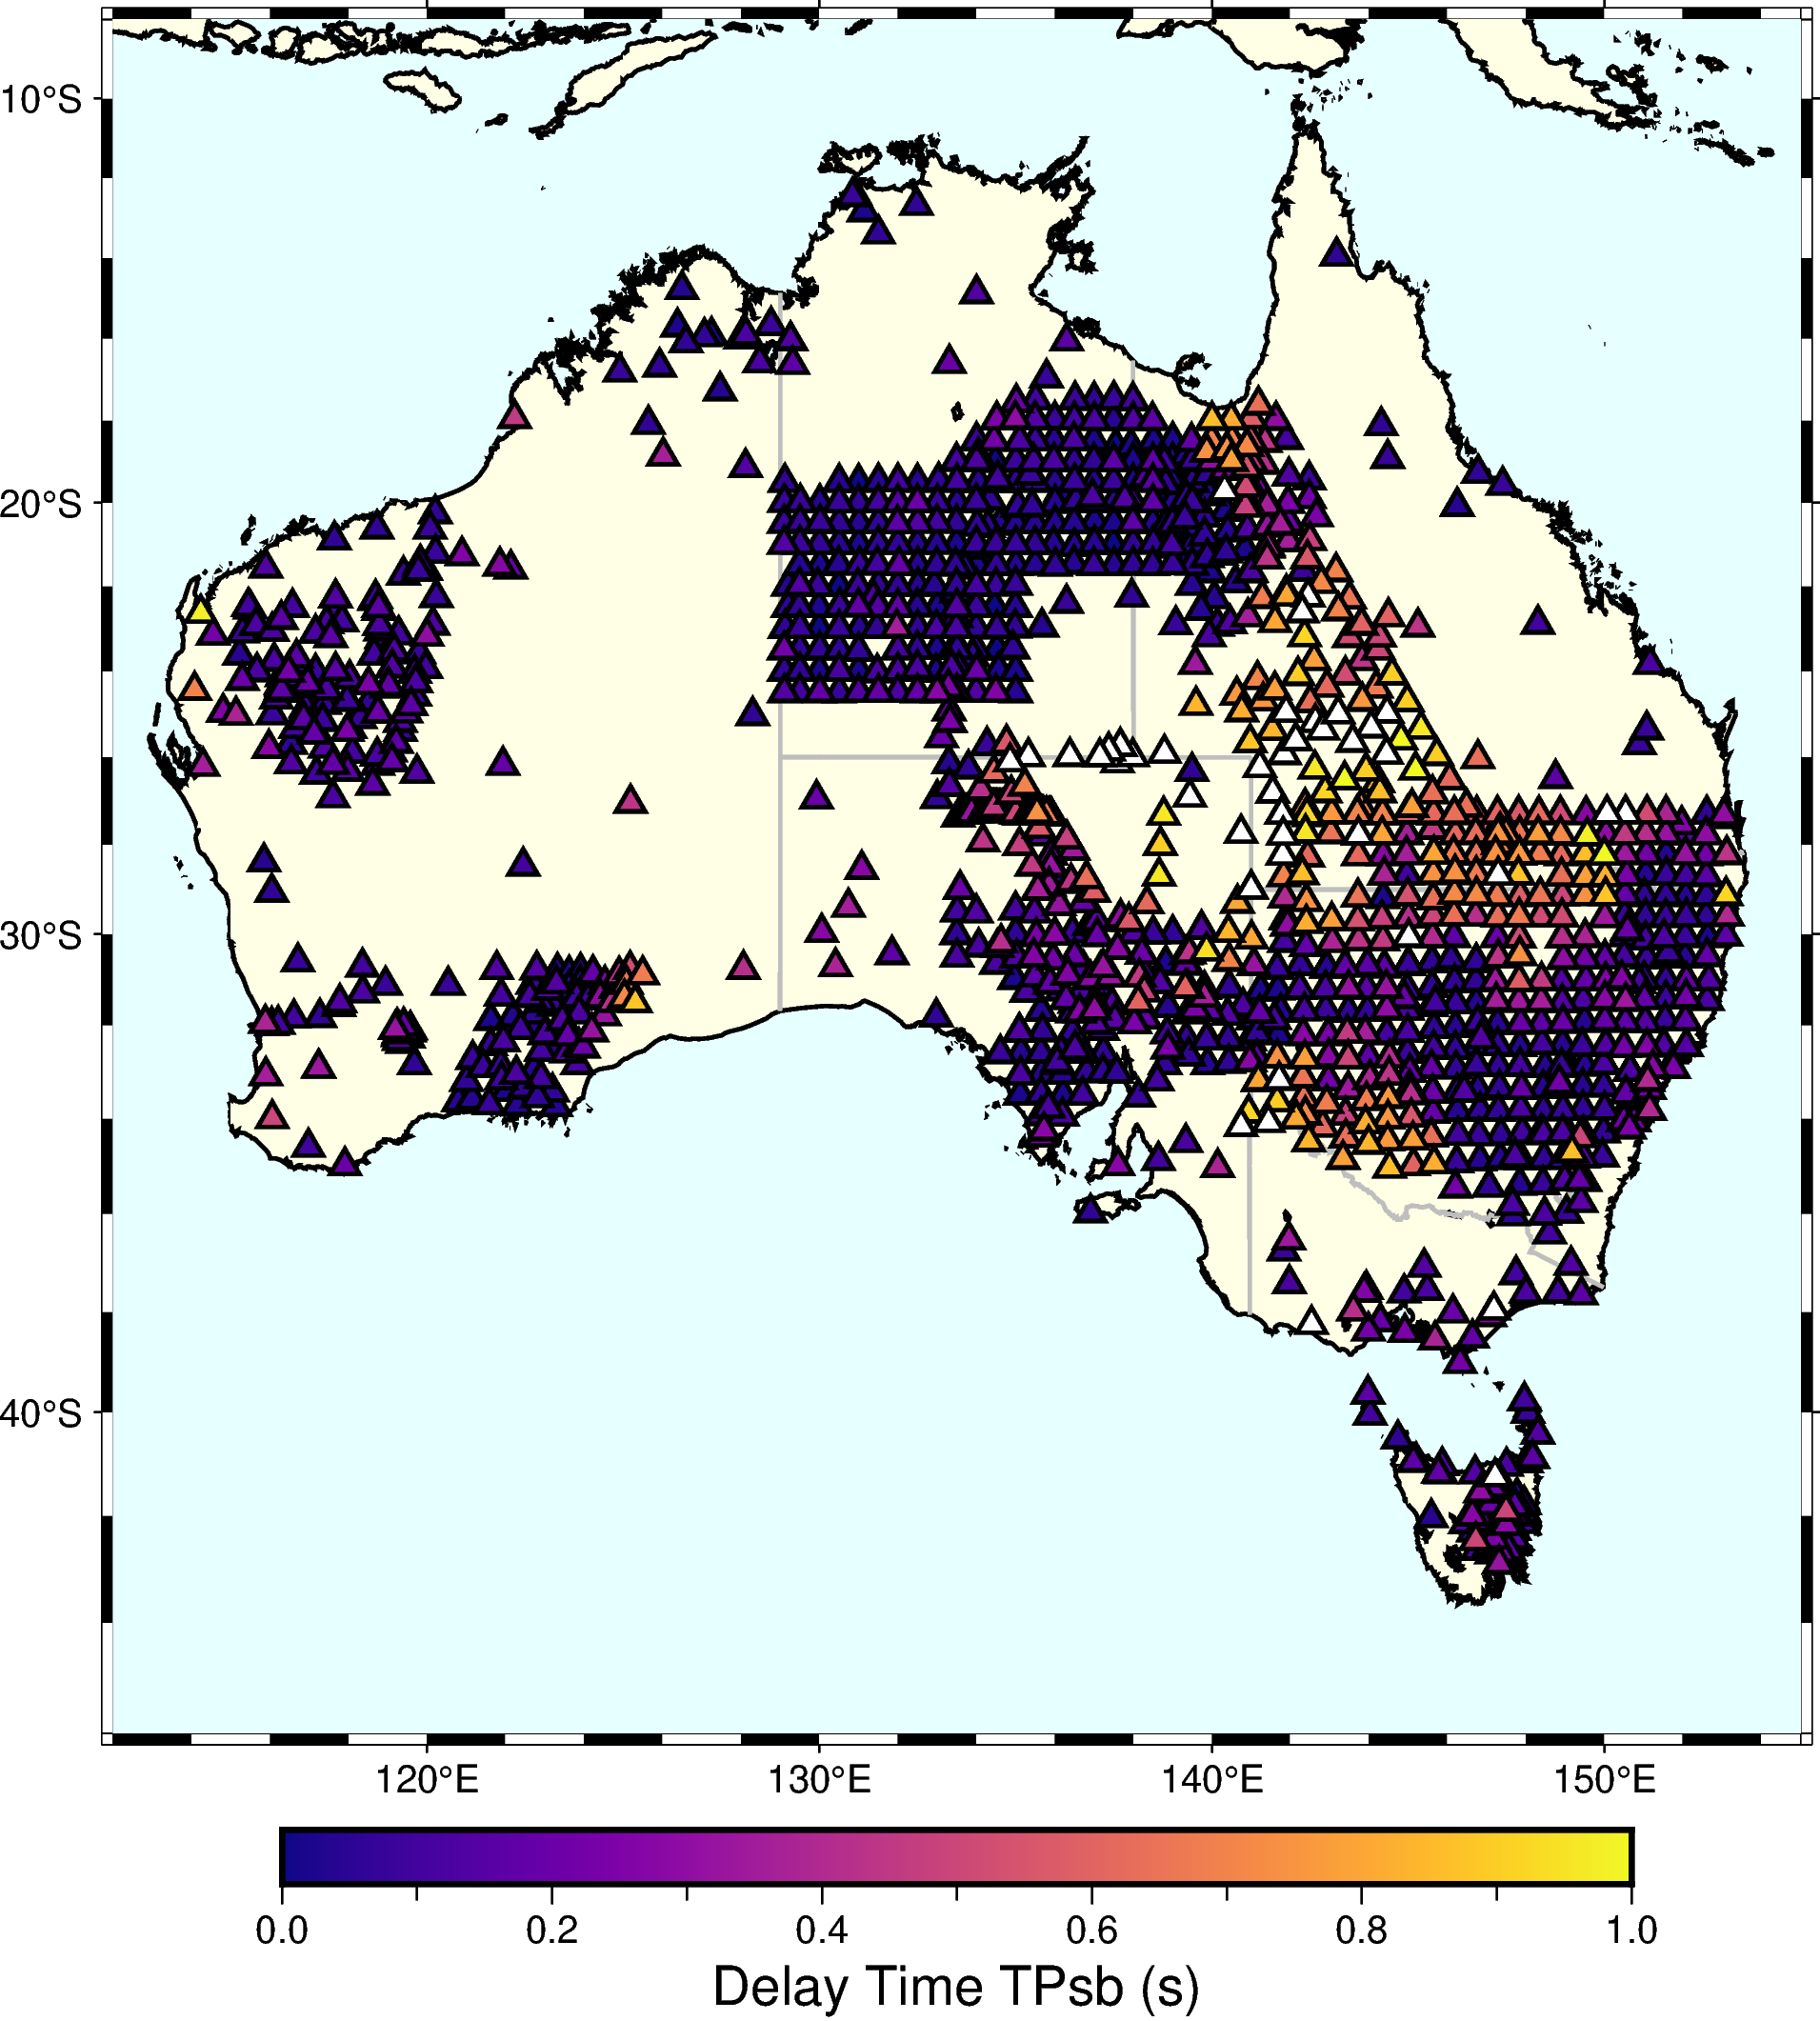

In [12]:
dry_run = False
if not dry_run:
    # Make output directories
    now = (datetime.now()).strftime(format="%Y%m%d_%H%M%S")
    processedroot = os.path.join(dataroot, "..", "processed")
    for net in networks:
        os.makedirs(os.path.join(processedroot, now, net))


    def plot_rfs_stacks_map(network, stream, stacks):
        outdir = os.path.join(processedroot, now, network)
        stations = set([stack.stats.station for stack in stacks])
        # plot RFs at each station
        for station in stations:
            rfs = stream.select(station=station)
            plot_name = os.path.join(outdir, f"{station}.pdf")
            fig = rfs.plot_rf(
                fname=plot_name,
                fig_width=4,
                fillcolors=("green", None),
                trace_height=0.1,
                scale=3,
                show_vlines=True,
                trim=(-2, 6),
            )  # this figure needs some bits to be moved around

        # Plot the stacked RFs of the network
        plot_name = os.path.join(outdir, f"stacks.pdf")
        fig = stacks.plot_rf(
            fname=plot_name,
            fig_width=4,
            fillcolors=("green", None),
            trace_height=0.1,
            scale=3,
            show_vlines=True,
            trim=(-2, 6),
            info=(),
        )  # customise this plot to use a colourmap

        # Plot map of network delay times
        plot_map(stacks, outdir)


    # Plots for each network
    Parallel(n_jobs=-1)(
        delayed(plot_rfs_stacks_map)(
            net, rfstream.select(network=net), rfstacks.select(network=net)
        ) for net in networks
    )

    # Plot the full map
    outdir = os.path.join(processedroot, now)
    plot_map(rfstacks, outdir, show=True)

    # Save the delay times in txt file
    with open(os.path.join(outdir, "delays.txt"), "w") as f:
        for stack in rfstacks:
            f.write(
                f"{stack.meta.network:4}\t{stack.meta.station:6}\t{stack.meta.station_longitude}\t{stack.meta.station_latitude}\t{stack.stats.delay:.3f}\n"
            )

    # Save the final RFs and stacks
    rfstream.write(os.path.join(outdir, "rfstream.h5"), format="H5")
    rfstacks.write(os.path.join(outdir, "rfstacks.h5"), format="H5")
